<div align="center">
    <h1><strong>Employee Iris Eye Recognition Code</strong></h1>
    <h3><strong>By : Aryan Sood & Ayush R. Nair</strong></h3>
</div>

<hr></hr>

## **Problem Statement**

This project addresses a classification problem involving iris images from multiple individuals, with each person having unique left and right iris images. The dataset contains 1,000 individuals, resulting in a total of 2,000 unique labels for classification.
## **About the Dataset**
The CASIA-Iris-Thousand dataset comprises 20,000 iris images from 1,000 individuals, collected using the IKEMB-100 camera. This dual-eye iris camera features a user-friendly interface with visual feedback on a frontal LCD screen, helping users align their pose for optimal image capture. The dataset includes intra-class variations caused by factors like eyeglasses and specular reflections. As the first publicly available iris dataset with 1,000 subjects, it is ideal for exploring the uniqueness of iris patterns and developing innovative classification and indexing techniques.
## **Software Requirements**  

This project utilized a range of software tools for implementation and testing. Table 1 provides an overview of the tools and their respective versions used.  

**Software Tools and Versions**  

| **Tool**               | **Version**          |  
|-------------------------|----------------------|  
| Python                 | 3.12.2              |  
| pandas                 | 2.2.2               |  
| numpy                  | 1.26.4              |  
| Pillow (PIL)           | 9.5.0               |  
| TensorFlow             | 2.15.0              |  
| OpenCV (cv2)           | 4.9.0               |  
| Keras (TensorFlow)     | Latest Version      |  
| matplotlib             | Latest Version      |  
| scikit-learn           | Latest Version      |  
| squarify               | Latest Version      |  
| Visual Studio Code     | Latest Version      |  
| torch                  | Latest Version      |  
| torchmetrics           | Latest Version      |  
The use of these tools and frameworks ensured efficient development and deployment of the project while maintaining compatibility and performance.

In [13]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn.metrics')

import squarify 
import os
import PIL
import math
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import tensorflow as tf
from keras import Sequential
from keras import backend as K
from tensorflow import keras as keras
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score,  roc_curve, confusion_matrix
from keras.layers import Layer, Input, Dense,Dropout, Conv2D, BatchNormalization, Flatten, Input, Conv2D, GaussianNoise,MaxPooling2D, Flatten, Dense, Dropout

import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.metrics import roc_curve, auc
from torchmetrics import Precision, Recall, Accuracy, AUROC

import numpy as np
from scipy.optimize import brentq
from scipy.interpolate import interp1d

In [14]:
def prepare_dataset(dataset_path):
    image_paths = []
    labels = []

    for person in os.listdir(dataset_path):
        person_folder = os.path.join(dataset_path, person)
        if os.path.isdir(person_folder):
            for eye_side in os.listdir(person_folder):  # left or right eye
                eye_folder = os.path.join(person_folder, eye_side)
                if os.path.isdir(eye_folder):
                    for image_file in os.listdir(eye_folder):
                        if not image_file.endswith('b'):  # exclude images ending with 'b'
                            image_paths.append(os.path.join(eye_folder, image_file))
                            labels.append(f"{person}-{eye_side}")

    dataset = pd.DataFrame({'Label': labels, 'ImagePath': image_paths})
    return dataset, labels, image_paths

In [19]:
df, labels, images = prepare_dataset('/kaggle/input/casia-iris-thousand/CASIA-Iris-Thousand/CASIA-Iris-Thousand')

In [20]:
def missing_values(df):
    missing_count = df.isnull().sum()
    missing_percetanges = pd.DataFrame({
        'Column': missing_count.index,
        'Counts': missing_count.values,
        'Percentage': (missing_count.values / len(df)) * 100  
    })
    return  missing_percetanges

In [21]:
def analyze_data(dataset):
    first_rows = dataset.head()
    last_rows = dataset.tail()
    unique_counts = dataset.nunique().reset_index(name="# of Unique")
    summary_stats = dataset.describe()
    column_types = dataset.dtypes.reset_index(name="Data Type")
    label_counts = dataset['Label'].value_counts()

    analysis_results = {
        'Table 2: First Few Rows': first_rows,
        'Table 3: Last Few Rows': last_rows,
        'Table 4: Numerical Summary Statistics': summary_stats,
        'Table 5: Missing Values Percentage': missing_values(dataset),
        'Table 6: Column Data Types': column_types,
        'Table 7: Count of Unique Values in Each Column': unique_counts,
        'Table 8: Label Distribution': label_counts
    }

    return analysis_results

In [23]:
def print_dataset_exploration(results):
    for operation, dataframe in results.items():
        print(f"{operation}")
        if operation == 'Table 6: Missing Values By Percentage':
            print("Total Sum of Missing Percetange: ", dataframe['Percentage'].sum())
        display(dataframe)

print_dataset_exploration(analyze_data(df))

Table 2: First Few Rows


,Label,ImagePath
0,437-R,/kaggle/input/casia-iris-thousand/CASIA-Iris-T...
1,437-R,/kaggle/input/casia-iris-thousand/CASIA-Iris-T...
2,437-R,/kaggle/input/casia-iris-thousand/CASIA-Iris-T...
3,437-R,/kaggle/input/casia-iris-thousand/CASIA-Iris-T...
4,437-R,/kaggle/input/casia-iris-thousand/CASIA-Iris-T...


Table 3: Last Few Rows


,Label,ImagePath
19995,715-L,/kaggle/input/casia-iris-thousand/CASIA-Iris-T...
19996,715-L,/kaggle/input/casia-iris-thousand/CASIA-Iris-T...
19997,715-L,/kaggle/input/casia-iris-thousand/CASIA-Iris-T...
19998,715-L,/kaggle/input/casia-iris-thousand/CASIA-Iris-T...
19999,715-L,/kaggle/input/casia-iris-thousand/CASIA-Iris-T...


Table 4: Numerical Summary Statistics


,Label,ImagePath
count,20000,20000
unique,2000,20000
top,715-L,/kaggle/input/casia-iris-thousand/CASIA-Iris-T...
freq,10,1


Table 5: Missing Values Percentage


,Column,Counts,Percentage
0,Label,0,0.0
1,ImagePath,0,0.0


Table 6: Column Data Types


,index,Data Type
0,Label,object
1,ImagePath,object


Table 7: Count of Unique Values in Each Column


,index,# of Unique
0,Label,2000
1,ImagePath,20000


Table 8: Label Distribution


Label
715-L    10
437-R    10
437-L    10
515-R    10
515-L    10
         ..
768-L    10
642-R    10
642-L    10
057-R    10
057-L    10
Name: count, Length: 2000, dtype: int64

In [25]:
import random
import math
import PIL.Image

def display_random_samples(dataset, num_samples):
    random.seed(1190652) 
    random_indices = random.sample(range(dataset.shape[0]), num_samples)
    rows_needed = math.ceil(num_samples / 4)

    fig, axes = plt.subplots(rows_needed, 4, figsize=(20, rows_needed * 5))  

    for i, idx in enumerate(random_indices):
        row = i // 4 
        col = i % 4  
        
        if idx < dataset.shape[0]:  
            image_path = dataset.loc[idx, "ImagePath"]
            image = PIL.Image.open(image_path)
            ax = axes[row, col] if rows_needed > 1 else axes[col]
            ax.imshow(image, cmap='gray')
            ax.set_title(f"Image {idx} - Person: {dataset.loc[idx, 'Label']}")
            ax.axis("off")

    plt.suptitle("Figure 3: Random Sample from the Dataset")
    plt.tight_layout()
    plt.show()

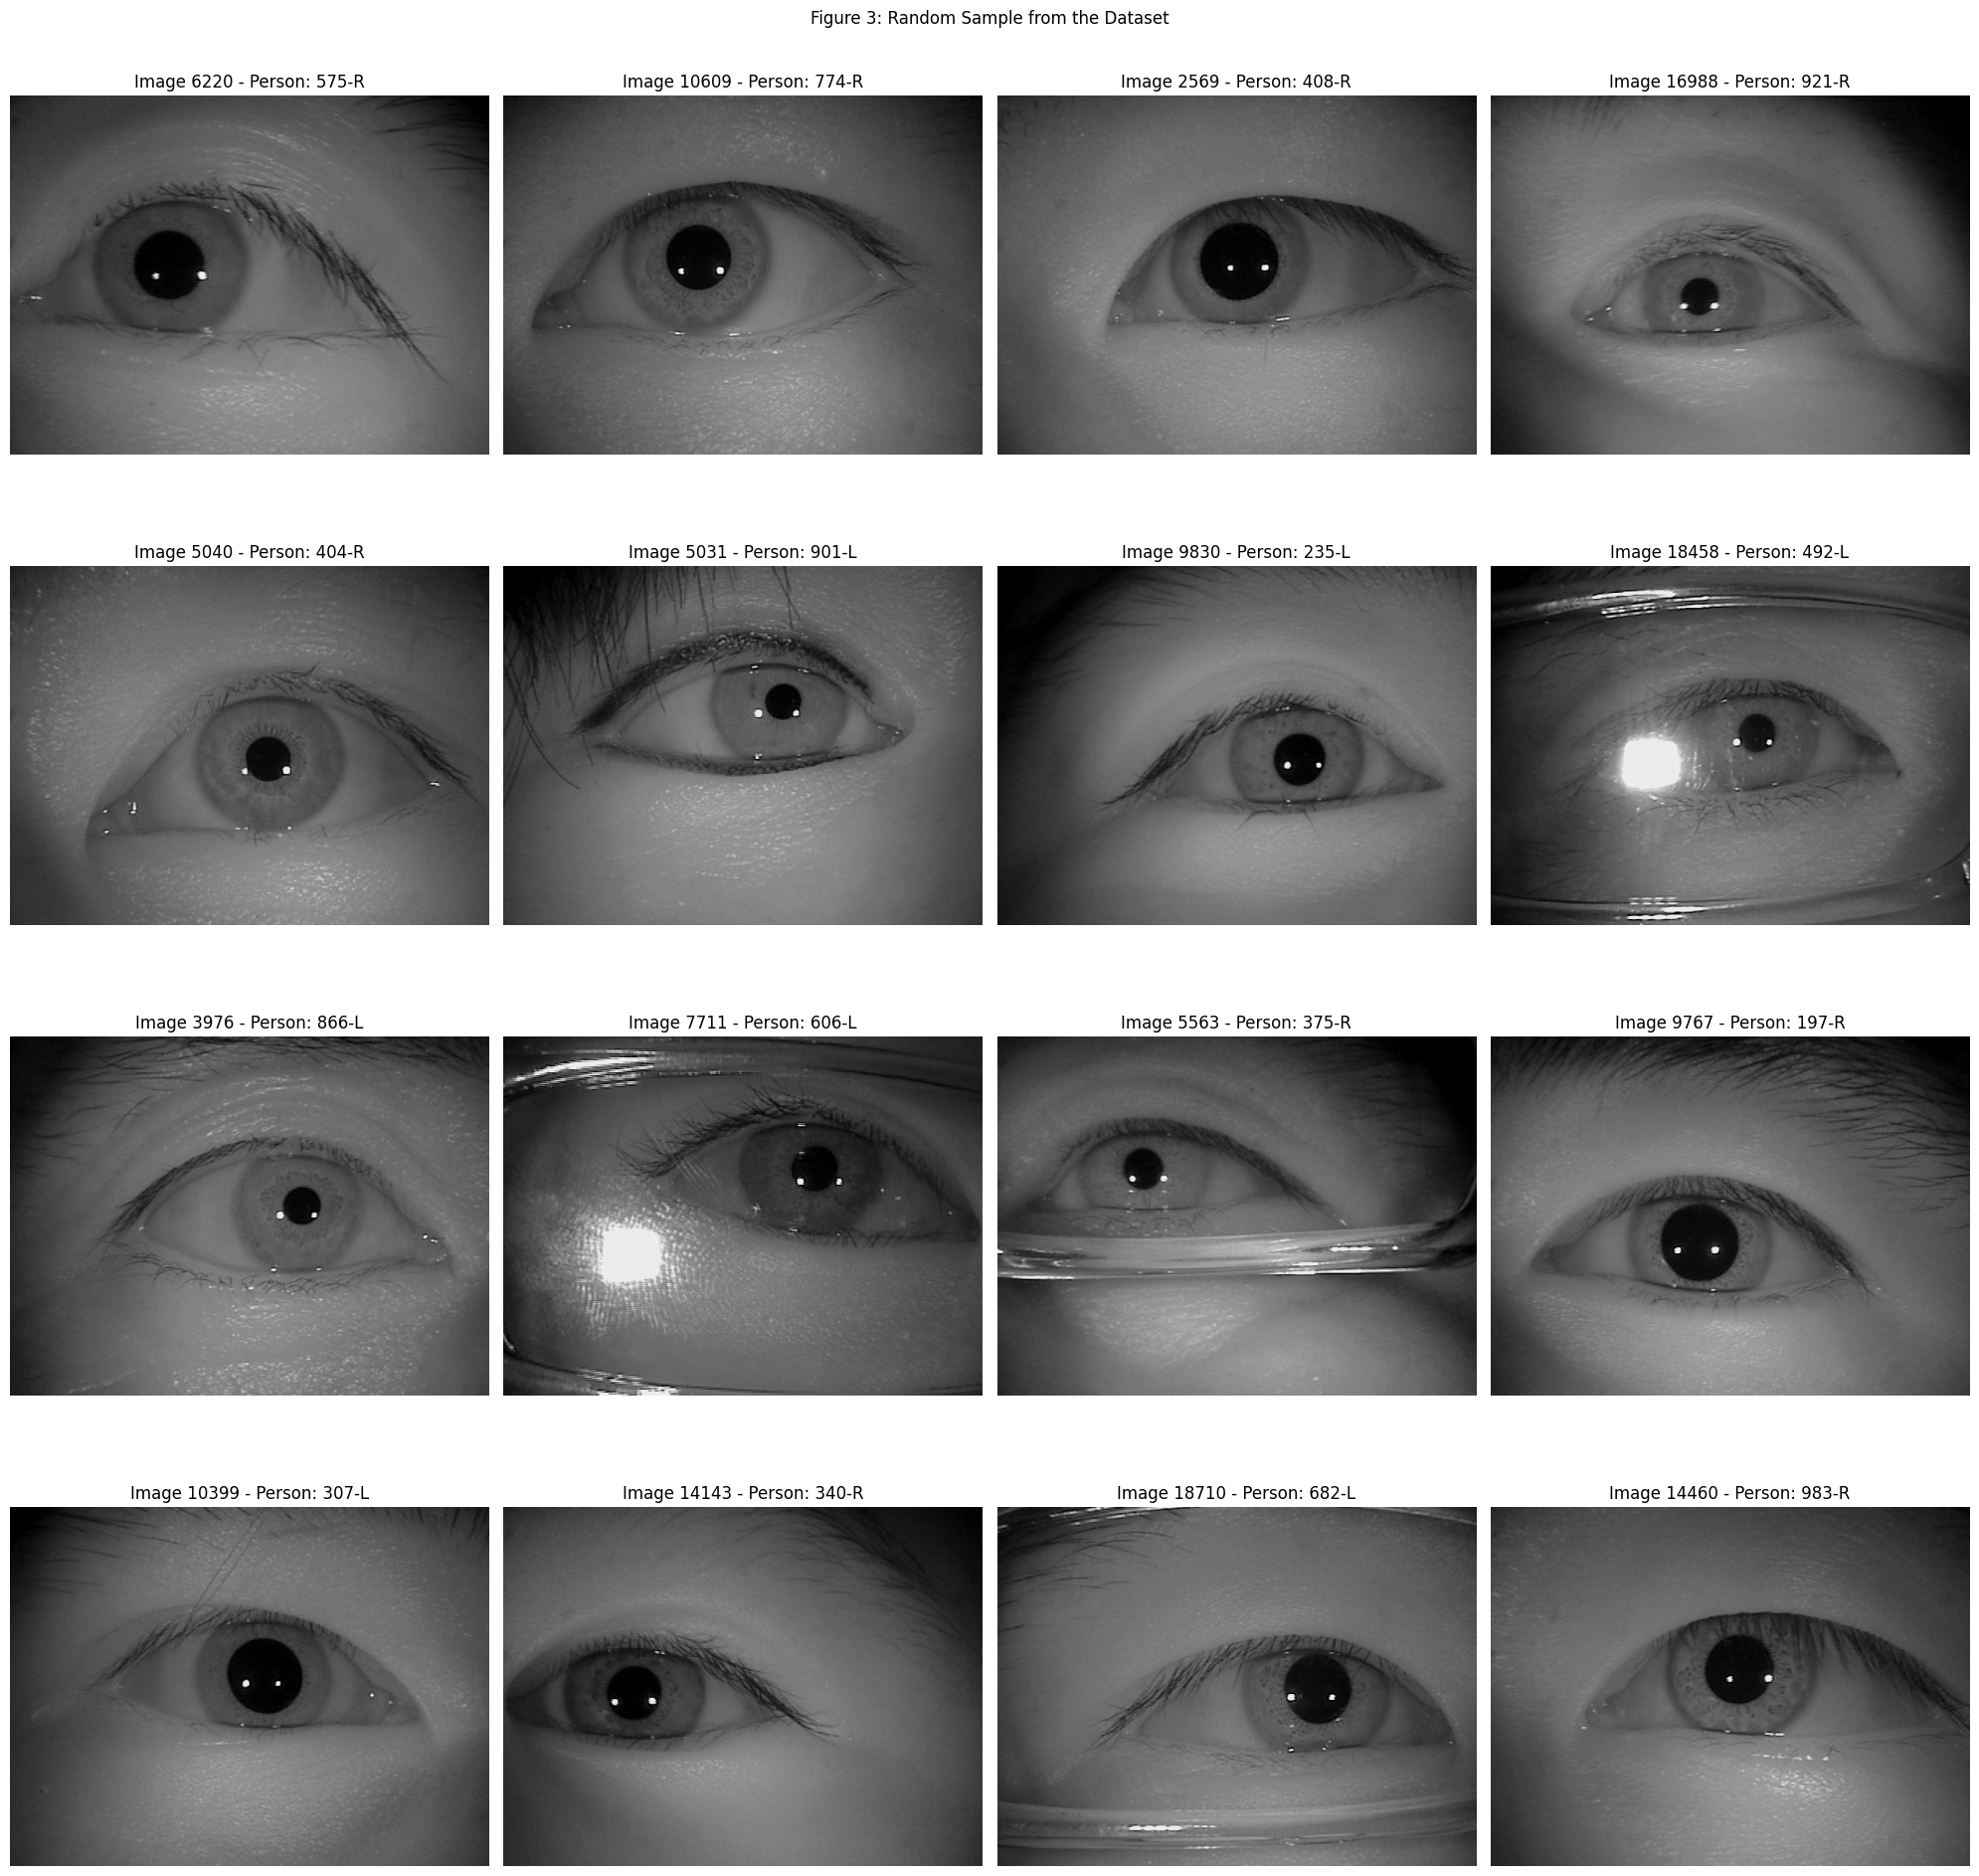

In [26]:
display_random_samples(df, 16)

In [28]:
SIZE = 20000
NUM_CLASSES = 2000
IMG_HEIGHT = 150
IMG_WIDTH = 150
NUM_CHANNELS = 1
input_shape=(IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)

In [29]:
def resize_keep_aspect_ratio(img, target_height=IMG_HEIGHT, target_width=IMG_WIDTH, pad_value=255):
    aspect_ratio = img.shape[1] / img.shape[0]
    
    if aspect_ratio > target_width / target_height:
        new_width = target_width
        new_height = int(target_width / aspect_ratio)
    else:
        new_height = target_height
        new_width = int(target_height * aspect_ratio)

    resized_img = cv2.resize(img, (new_width, new_height))
    preprocessed_img = np.full((target_height, target_width), pad_value, dtype=np.uint8)
    
    x_offset = (target_width - new_width) // 2
    y_offset = (target_height - new_height) // 2
    
    preprocessed_img[y_offset:y_offset + new_height, x_offset:x_offset + new_width] = resized_img
    
    return preprocessed_img

In [30]:
def preprocess_image_final(img_dir):
    img = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    img = resize_keep_aspect_ratio(img)
    img = img/255.
    
    return img

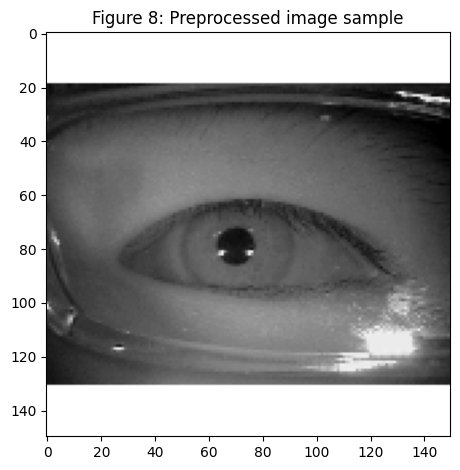

In [31]:
plt.imshow(preprocess_image_final(df.iloc[20]['ImagePath']), cmap="gray")
plt.title("Figure 8: Preprocessed image sample")
plt.tight_layout()
plt.show()

In [33]:
# Labels
def preprocess_labels_final(df):
    labels = df['Label'].astype(str)
    le = LabelEncoder()
    le.fit(labels)
    labels = le.transform(labels)
    return labels

In [34]:
print("Label after encoding: ", preprocess_labels_final(df)[10])
print("Label before encoding: ",df.iloc[10]['Label'])

Label after encoding:  874
Label before encoding:  437-L


In [35]:
def split_dataset(preprocessed_images, preprocessed_labels, train_size=0.8, validation_size=0.1, shuffle=True):
    np.random.seed(1190652)
    total_samples = preprocessed_images.shape[0]
    indices = np.arange(total_samples)
    
    if shuffle:
        np.random.shuffle(indices)
    
    train_samples = int(total_samples * train_size)
    validation_samples = int(total_samples * validation_size)
    
    train_indices = indices[:train_samples]
    validation_indices = indices[train_samples:train_samples + validation_samples]
    test_indices = indices[train_samples + validation_samples:]
    
    x_train = preprocessed_images[train_indices]
    y_train = preprocessed_labels[train_indices]
    x_valid = preprocessed_images[validation_indices]
    y_valid = preprocessed_labels[validation_indices]
    x_test = preprocessed_images[test_indices]
    y_test = preprocessed_labels[test_indices]
    
    return x_train, x_valid, x_test, y_train, y_valid, y_test

In [36]:
def prepare_data(df):
    preprocessed_images = [preprocess_image_final(images[i]) for i in range(SIZE)]
    preprocessed_images = np.array(preprocessed_images).reshape(-1, IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)
    preprocessed_labels = preprocess_labels_final(df)
    return split_dataset(preprocessed_images, preprocessed_labels)

In [37]:
x_train, x_valid, x_test, y_train, y_valid, y_test = prepare_data(df)
print("Triaing set size: ", x_train.shape)
print("Validation set size: ", x_valid.shape)
print("Testing set size: ",x_test.shape)

Triaing set size:  (16000, 150, 150, 1)
Validation set size:  (2000, 150, 150, 1)
Testing set size:  (2000, 150, 150, 1)


In [38]:
class CentralCrop(Layer):
    def __init__(self, central_fraction=0.5):
        super().__init__()
        self.central_fraction = central_fraction

    def call(self, inputs):
        return tf.image.central_crop(inputs, central_fraction=self.central_fraction)

In [39]:
data_augmentation = keras.Sequential([
    Input(shape=input_shape),
    CentralCrop(central_fraction=0.5)  
])

augmented_images = data_augmentation(x_train)  

In [40]:
EPOCHS = 100
BATCH_SIZE = 32
loss = 'sparse_categorical_crossentropy'
activation = "leaky_relu"
initial_learning_rate = 0.001
optimizer = Adam(learning_rate=initial_learning_rate)

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
checkpt = ModelCheckpoint('.mdl_wts.keras', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

In [41]:
# MODEL ARCH INSPIRED FROM GITHUB
def compile_model():
    padding = 'same'
    poolpadding = 'valid'

    model = Sequential([
        Input(input_shape),
        
        Conv2D(32, (5, 5), padding=padding, activation=activation, name="Conv1"),
        BatchNormalization(axis=-1, name="BN1"),  
        MaxPooling2D(pool_size=(2, 2), padding=poolpadding, name="Mpool1"),
        GaussianNoise(0.1, name="GaussianNoise"), 
        Dropout(0.1, name="Dropout1"),

        Conv2D(64, (5, 5), padding=padding, activation=activation, name="Conv2"),
        BatchNormalization(axis=-1, name="BN2"),  
        MaxPooling2D(pool_size=(2, 2), padding=poolpadding, name="Mpool2"),
        Dropout(0.1, name="Dropout2"),

        Conv2D(128, (5, 5), padding=padding, activation=activation, name="Conv3"),
        BatchNormalization(axis=-1, name="BN3"),  
        MaxPooling2D(pool_size=(2, 2), padding=poolpadding, name="Mpool3"),
        Dropout(0.25, name="Dropout3"),

        Conv2D(256, (3, 3), padding=padding, activation=activation, name="Conv4"),
        BatchNormalization(axis=-1, name="BN4"),  
        MaxPooling2D(pool_size=(2, 2), padding=poolpadding, name="Mpool4"),
        Dropout(0.25, name="Dropout4"),

        Conv2D(256, (3, 3), padding=padding, activation=activation, name="Conv5"),
        BatchNormalization(axis=-1, name="BN5"),  
        MaxPooling2D(pool_size=(2, 2), padding=poolpadding, name="Mpool5"),
        Dropout(0.25, name="Dropout5"),
        
        Conv2D(512, (3, 3), padding=padding, activation=activation, name="Conv6"),
        BatchNormalization(axis=-1, name="BN6"),  
        MaxPooling2D(pool_size=(2, 2), padding=poolpadding, name="Mpool6"),
        Dropout(0.45, name="Dropout6"),
        
        Conv2D(512, (2, 2), padding=padding, activation=activation, name="Conv7"),
        BatchNormalization(axis=-1, name="BN7"),  
        MaxPooling2D(pool_size=(2, 2), padding=poolpadding, name="Mpool7"),
        Dropout(0.5, name="Dropout7"),
        
        Flatten(),
        Dense(128, activation=activation, name = "Dense1"),
        Dense(2000, activation='softmax', name="SoftmaxClasses"),
    ],
    name="IRISRecognizer")
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    return model

In [42]:
model = compile_model()
model.summary()

Model: "IRISRecognizer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv1 (Conv2D)                       │ (None, 150, 150, 32)        │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BN1 (BatchNormalization)             │ (None, 150, 150, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Mpool1 (MaxPooling2D)                │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GaussianNoise (GaussianNoise)        │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout1 (Dropout)                   │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2 (Conv2D)                       │ (None, 75, 75, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BN2 (BatchNormalization)             │ (None, 75, 75, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Mpool2 (MaxPooling2D)                │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout2 (Dropout)                   │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3 (Conv2D)                       │ (None, 37, 37, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BN3 (BatchNormalization)             │ (None, 37, 37, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Mpool3 (MaxPooling2D)                │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout3 (Dropout)                   │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv4 (Conv2D)                       │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BN4 (BatchNormalization)             │ (None, 18, 18, 256)         │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Mpool4 (MaxPooling2D)                │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout4 (Dropout)                   │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv5 (Conv2D)                       │ (None, 9, 9, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BN5 (BatchNormalization)             │ (None, 9, 9, 256)           │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Mpool5 (MaxPooling2D)                │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout5 (Dropout)                   │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,702,224 (14.12 MB)

 Trainable params: 3,698,704 (14.11 MB)

 Non-trainable params: 3,520 (13.75 KB)

In [43]:
history = model.fit(np.array(x_train), y_train, validation_data=(np.array(x_valid), y_valid), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[earlyStopping, checkpt, reduce_lr_loss])

Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 49ms/step - accuracy: 0.0011 - loss: 7.6487 - val_accuracy: 0.0010 - val_loss: 9.3867 - learning_rate: 0.0010
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.0153 - loss: 6.3591 - val_accuracy: 0.0195 - val_loss: 6.3277 - learning_rate: 0.0010
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.0508 - loss: 5.3044 - val_accuracy: 0.0335 - val_loss: 6.5621 - learning_rate: 0.0010
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - accuracy: 0.1479 - loss: 4.2466 - val_accuracy: 0.1575 - val_loss: 4.5789 - learning_rate: 0.0010
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - accuracy: 0.2613 - loss: 3.2849 - val_accuracy: 0.1330 - val_loss: 5.0221 - learning_rate: 0.0010
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 26s 53ms/step - accuracy: 0.4049 - loss: 2.4970 - val_accuracy: 0.4145 - val_loss: 2.6360 - learning_rate: 0.0010
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 26s 52ms/step - accuracy: 0.5

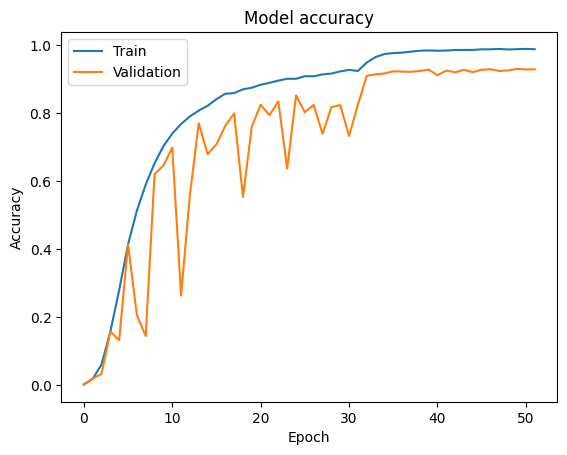

In [44]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

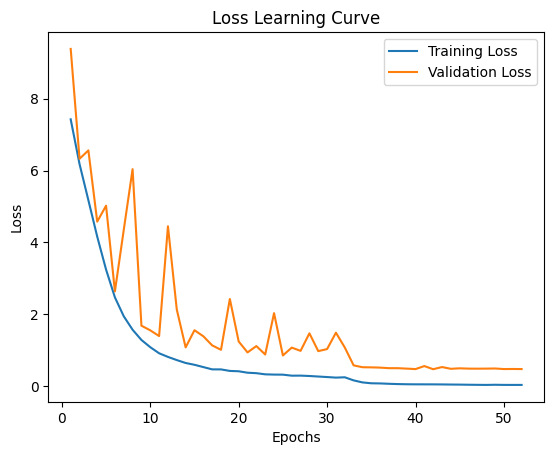

In [45]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Loss Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [46]:
model.save("IRISRecognizer.h5")
reconstructed_model = keras.models.load_model("IRISRecognizer.h5")
test_loss, test_acc = reconstructed_model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc*100:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9288 - loss: 0.5383
Test accuracy: 92.900


In [47]:
def evaluate_model_visualize(dataset, y_true, model, class_names):
    num_rows = 4
    num_cols = 6
    data_batch = dataset[0:num_rows * num_cols]
    predictions = model.predict(data_batch)
    plt.figure(figsize=(20, 8))
    num_matches = 0

    for idx in range(num_rows * num_cols):
        ax = plt.subplot(num_rows, num_cols, idx + 1)
        plt.axis("off")
        plt.imshow(data_batch[idx], cmap="gray")

        pred_idx = np.argmax(predictions[idx])
        true_idx = y_true[idx]

        title = f"{class_names[true_idx]} : {class_names[pred_idx]}"
        title_obj = plt.title(title, fontdict={"fontsize": 13})

        if pred_idx == true_idx:
            num_matches += 1
            plt.setp(title_obj, color="g")
        else:
            plt.setp(title_obj, color="r")
    acc = num_matches / (num_rows * num_cols)
    print("Prediction accuracy: {:.2%}".format(acc))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction accuracy: 95.83%


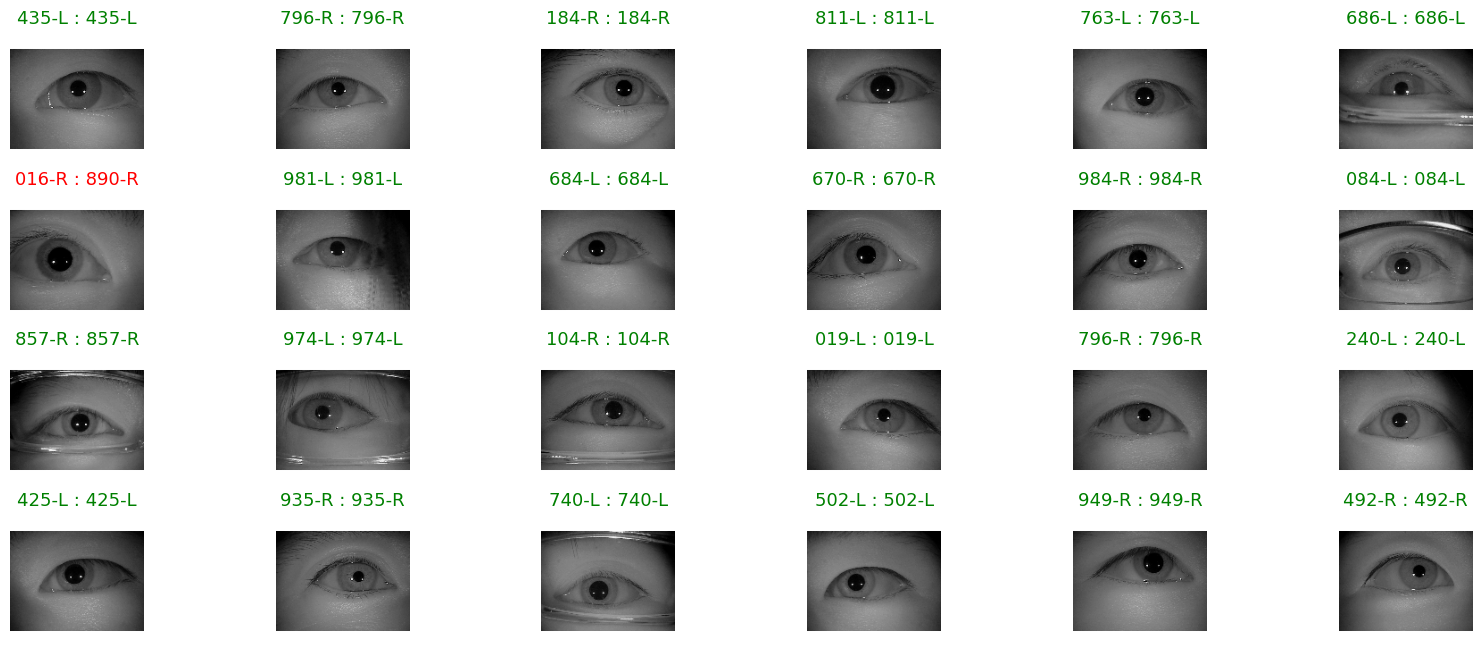

In [48]:
evaluate_model_visualize(x_test,y_test, reconstructed_model,df['Label'].unique())